In [1]:
import os
import torch

In [2]:
imgs_folder = 'database_T2/'

In [3]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
from docarray import DocumentArray

imgs = DocumentArray.from_files(f"{imgs_folder}*.jpg")

In [6]:
from docarray import Document


def preproc(d: Document):
    return (
        d.load_uri_to_image_tensor()  # load
        .set_image_tensor_normalization()  # normalize color
        .set_image_tensor_channel_axis(-1, 0)
    )  # switch color axis for the PyTorch model later


imgs.apply(preproc)

╭─────────────────────── Documents Summary ───────────────────────╮
│                                                                 │
│   Type                   DocumentArrayInMemory                  │
│   Length                 366                                    │
│   Homogenous Documents   True                                   │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri')   │
│   Multimodal dataclass   False                                  │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   id          ('str',)       366              False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   366              False             │
│   uri         ('str',)       366              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

In [7]:
import torchvision

model = torchvision.models.resnet50(pretrained=True)  # load ResNet50
imgs.embed(model, device=device, batch_size=1)  # embed

/home/zo/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zo/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


╭───────────────────────────── Documents Summary ──────────────────────────────╮
│                                                                              │
│   Type                   DocumentArrayInMemory                               │
│   Length                 366                                                 │
│   Homogenous Documents   True                                                │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')   │
│   Multimodal dataclass   False                                               │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('Tensor',)    366              False             │
│   id          ('str',)       366              False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   366              False             │
│   uri         ('str',)       366              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

In [8]:
# imgs.plot_embeddings(image_sprites=True, image_source='uri', min_image_size=128, host="localhost")

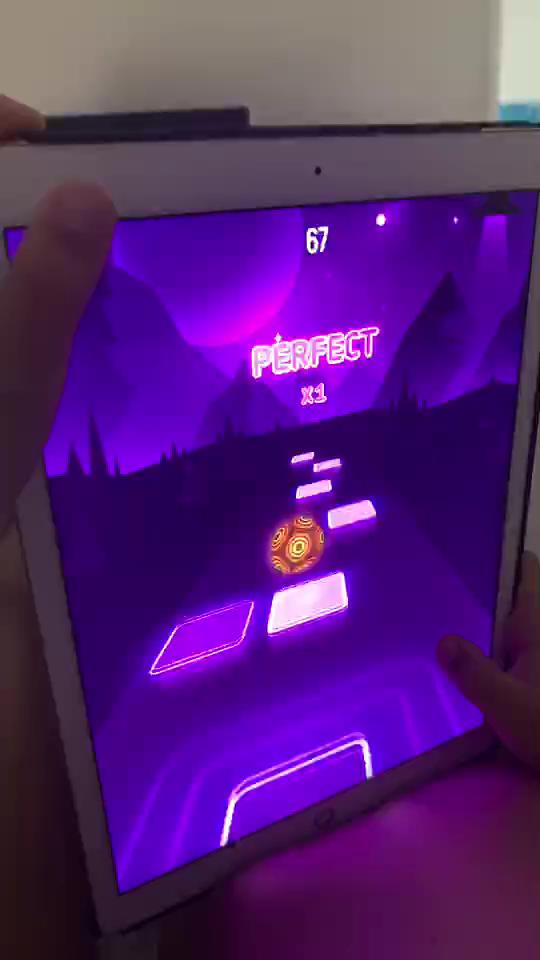

In [9]:
query_img_path = 'database_T2/75.jpg'
query_doc = Document(uri=query_img_path)
query_doc.display()

In [10]:
query_docs = DocumentArray([query_doc])
query_docs.apply(preproc)
query_docs.embed(model, device='cuda')

╭───────────────────────────── Documents Summary ──────────────────────────────╮
│                                                                              │
│   Type                   DocumentArrayInMemory                               │
│   Length                 1                                                   │
│   Homogenous Documents   True                                                │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')   │
│   Multimodal dataclass   False                                               │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('Tensor',)    1                False             │
│   id          ('str',)       1                False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   1                False             │
│   uri         ('str',)       1                False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

In [11]:
query_docs.match(imgs, limit=8)

In [12]:
query_docs[0].matches[1].uri

'database_T2/74.jpg'

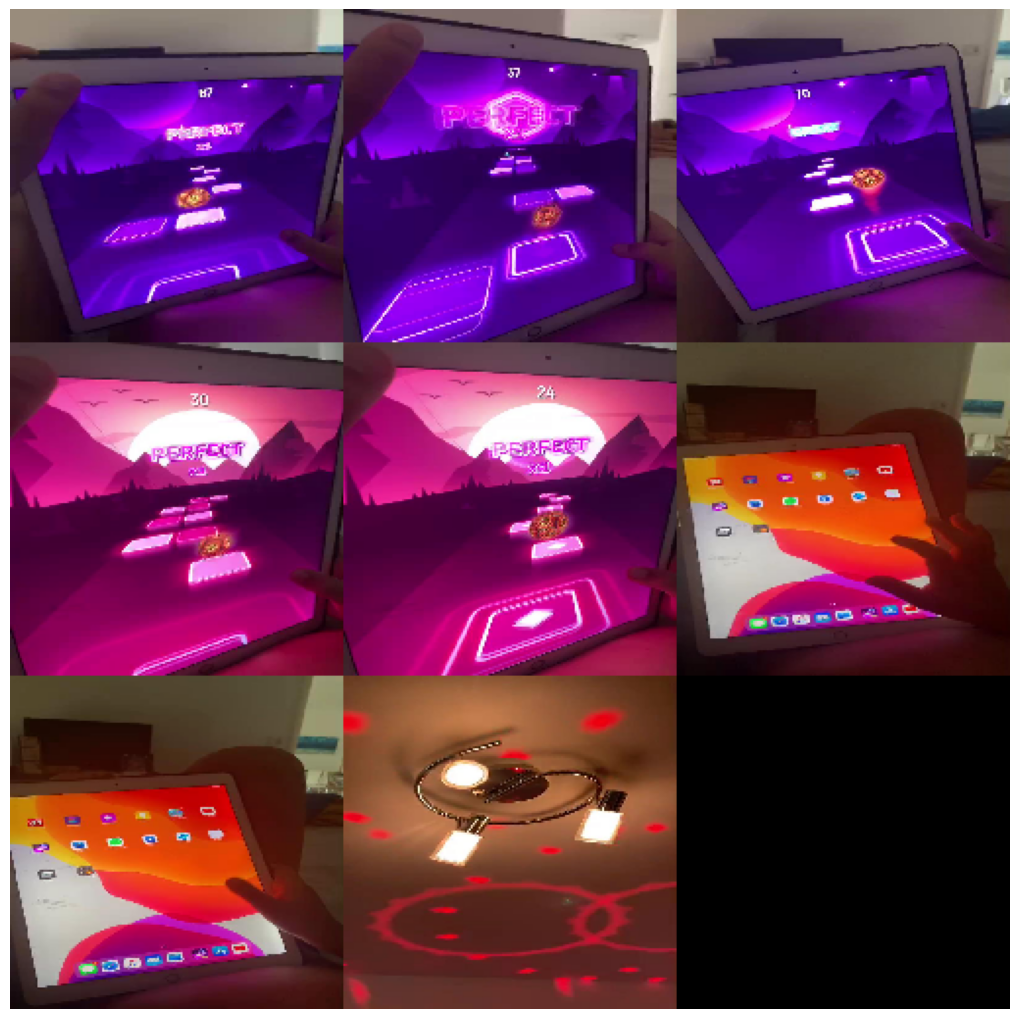

In [13]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())).plot_image_sprites()

In [14]:
# for i in os.listdir(img_folder):
#     img_path = os.path.join(img_folder, i)
#     print(img_path)
#     break
#     query_img_path = 'database_T2/75.jpg'
#     query_doc = Document(uri=query_img_path)
#     query_doc.display()
#
#     query_docs = DocumentArray([query_doc])
#     query_docs.apply(preproc)
#     query_docs.embed(model, device=device)
#
#     query_docs.match(imgs, limit=8)
#     for i in range(5):
#         query_docs[0].matches[i].uri

In [15]:
import faiss
import numpy as np
import cv2

from src.cnn_feature_extractor import FeatureExtractor

In [17]:
cnn_feature_extractor = FeatureExtractor(device=device)

self.device='cuda:0'


In [18]:
def extract_vectors(imgs_folder: str):

    id_to_img_path = {}
    vectors = []
    for i, img in enumerate(os.listdir(imgs_folder)):
        img_path = os.path.join(imgs_folder, img)
        id_to_img_path[i] = img_path
        bgr_img = cv2.imread(img_path)
        vector = cnn_feature_extractor.extract(bgr_img)
        vectors.append(vector)
    return vectors, id_to_img_path

vectors, id_map = extract_vectors(imgs_folder=imgs_folder)
print(f"{len(vectors)=}")

len(vectors)=366


In [19]:
# id_map

In [20]:
x = np.vstack(vectors)
x.shape

(366, 2048)

In [21]:
d = x.shape[1]
print(f"{d=}")

index = faiss.IndexFlatL2(d)
index.add(x)


d=2048


In [22]:
type(x)

numpy.ndarray

In [23]:
a = np.array([103.2,  155.44818, 167.61473, 170.57948, 189.66765, 197.1431,
 204.2556, 206.02321, 210.58495 ])

valid = np.argwhere(a < 110)
print(valid)


[[0]]


In [25]:
from shutil import copy

# let's have a threshold of thresh = 150
free_images: set = set(id_map.values())
taken_images: set = set()
bucket: int = 0
threshold = 150.0

grouped_img_dir = 'grouped/'
if not os.path.exists(grouped_img_dir):
    os.mkdir(grouped_img_dir)

for v in vectors[::]:
    distances, indexes = index.search(np.expand_dims(v, axis=0), 10)  # searching by one vector at a time for convenience in debugging (would use batch search otherwise)
    # print(f"{distances=}, {indexes=}")
    distances = distances[0][0:]
    indexes = indexes[0][0:]


    print(f"{distances}")
    valid = np.argwhere(distances < threshold)
    print(f"{valid=}")

    print(f"{indexes=}")
    indexes = indexes[valid].tolist()
    print(f"{indexes=}")
    img_names = [id_map[i[0]] for i in indexes]
    print(f"{img_names=}")

    img_names = [i for i in img_names if i in free_images]
    print(img_names)
    n_sim_imgs = len(img_names)
    print(f"{n_sim_imgs=}")
    if n_sim_imgs > 1:
        bucket += 1
        bucket_path = os.path.join(grouped_img_dir, str(bucket))
        if not os.path.exists(bucket_path):
            os.mkdir(bucket_path)
        for i in img_names:
            free_images.remove(i)
            taken_images.add(i)
            dst = os.path.join(bucket_path, i.split("/")[-1])
            copy(i, dst)
    # break

[  0.       103.217606 155.44818  167.61473  170.57948  189.66765
 197.14316  204.2556   206.02321  210.58495 ]
valid=array([[0],
       [1]])
indexes=array([  0, 233, 254, 175, 292,  60,  88, 121,  75, 301])
indexes=[[0], [233]]
img_names=['database_T2/197.jpg', 'database_T2/198.jpg']
['database_T2/197.jpg', 'database_T2/198.jpg']
n_sim_imgs=2
[  0.        32.108997 165.08136  188.18054  197.23393  204.56139
 208.77295  209.78462  211.76787  212.52652 ]
valid=array([[0],
       [1]])
indexes=array([  1,  85, 278,  54, 306,   9, 273,  43, 302,  61])
indexes=[[1], [85]]
img_names=['database_T2/245.jpg', 'database_T2/246.jpg']
['database_T2/245.jpg', 'database_T2/246.jpg']
n_sim_imgs=2
[  0.       87.92943 101.51914 101.51914 129.35    142.85092 192.64882
 201.38419 203.60007 227.14418]
valid=array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])
indexes=array([  2, 328,  91, 338,  19, 161,  43, 210, 306, 279])
indexes=[[2], [328], [91], [338], [19], [161]]
img_names=['

In [26]:
# fasiss stuff

ncentroids = 122 # number of images / 3
niter = 20
verbose = True
d = x.shape[1]
print(f"{d=}")
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(x)

d=2048
Clustering 366 points in 2048D to 122 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s


WARNING clustering 366 points to 122 centroids: please provide at least 4758 training points


17278.892578125

In [27]:
D, I = kmeans.index.search(x, 1)

In [28]:
def get_img_color_hist(image, binsize: int = 100):
    """
    Given an image as input, output its color histogram as a numpy array.
    Binsize will determine the size
    """

    chans = cv2.split(image)
    main = np.zeros((0,1))

    # loop over the image channels
    for chan in chans:
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [binsize], [0, 256])
        main = np.append(main,hist)

    # normalize so sum of all values equals 1
    main = main / (image.shape[0] * image.shape[1])

    return main.astype('float32')